<h1 style="color:#e8710a">1) Importing used Libraries</h1>

In [1]:
import pandas as pd
from PIL import Image
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import plot_model

<h1 style="color:#e8710a">2) Define paths and parameters</h1>

In [2]:
# Define image size and batch size
IMG_SIZE = 224

# Define train, test, and validation directories
train_dir = '/kaggle/input/egyptian-new-currency-2023/dataset/train'
val_dir = '/kaggle/input/egyptian-new-currency-2023/dataset/valid'
test_dir = '/kaggle/input/egyptian-new-currency-2023/dataset/test'

class_names = sorted([dir_name for dir_name in os.listdir(train_dir)])

<h1 style="color:#e8710a">3) Reading The Images and Labels</h1>

In [3]:
def read_images_from_folder(folder_path):
    images = []
    labels = []
    
#     ignore_classes = ['1','10', '100', '50', '20', '200', '5']
    ignore_classes = ['1']
    for class_folder in tqdm(os.listdir(folder_path)):
        # Skip processing images from the specified ignored classes
        if ignore_classes and class_folder.lower() in ignore_classes:
            continue
            
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            label = class_folder
            
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                
                # Reading the image and converting it to a numpy array
                img = Image.open(image_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
                img_array = np.array(img, dtype=np.uint8)

                images.append(img_array)
                labels.append(label)
    
    return np.array(images), np.array(labels)

train_images, train_labels  = read_images_from_folder(train_dir)
valid_images, valid_labels  = read_images_from_folder(val_dir)
test_images, test_labels = read_images_from_folder(test_dir)

100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


<h1 style="color:#e8710a">4) Some insights about the dataset</h1>

In [4]:
num_classes = len(np.unique(train_labels))
Classes = np.unique(train_labels)
print(f"Classes: {Classes}")
print(f"Number of classes: {num_classes}")

Classes: ['10' '10 (new)' '100' '20' '20 (new)' '200' '5' '50']
Number of classes: 8


In [5]:
def image_statistics(images, dataset_name):
    print(f"Dataset: {dataset_name}")
    print(f"Number of images: {len(images)}")
    
    # Calculate statistics about image shapes
    print(f"Image shapes: {images.shape}")
    print("------------------------------")

    

# Example usage:
image_statistics(train_images, "Train")
image_statistics(valid_images, "Validation")
image_statistics(test_images, "Test")

Dataset: Train
Number of images: 2577
Image shapes: (2577, 224, 224, 3)
------------------------------
Dataset: Validation
Number of images: 740
Image shapes: (740, 224, 224, 3)
------------------------------
Dataset: Test
Number of images: 270
Image shapes: (270, 224, 224, 3)
------------------------------




###  Balanced Data Analysis


This cell analyzes the distribution of samples across different classes in the training dataset. The goal is to check if the dataset is balanced, meaning that each class has an equal number of samples. A balanced dataset helps ensure that the model doesn't favor one class over another, leading to more reliable predictions.



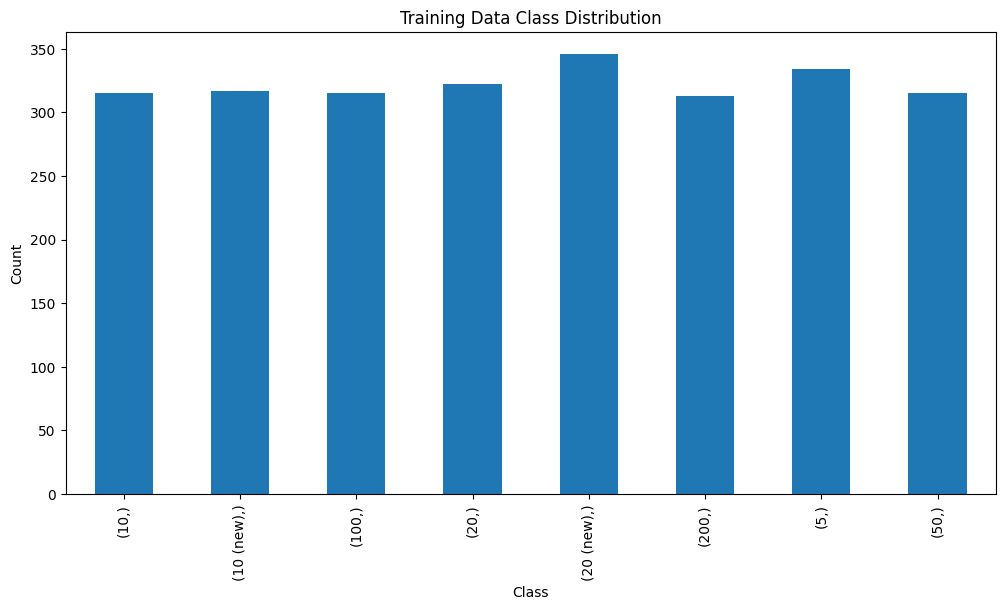

In [6]:
plt.figure(figsize=(12, 6))
pd.DataFrame(train_labels).value_counts().sort_index().plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Displaying Random Images from the Dataset

In this cell, we display random samples of images from the dataset along with their corresponding labels. This is done to visually inspect the data and ensure that the images are correctly labeled. The number of samples displayed can be adjusted as needed.


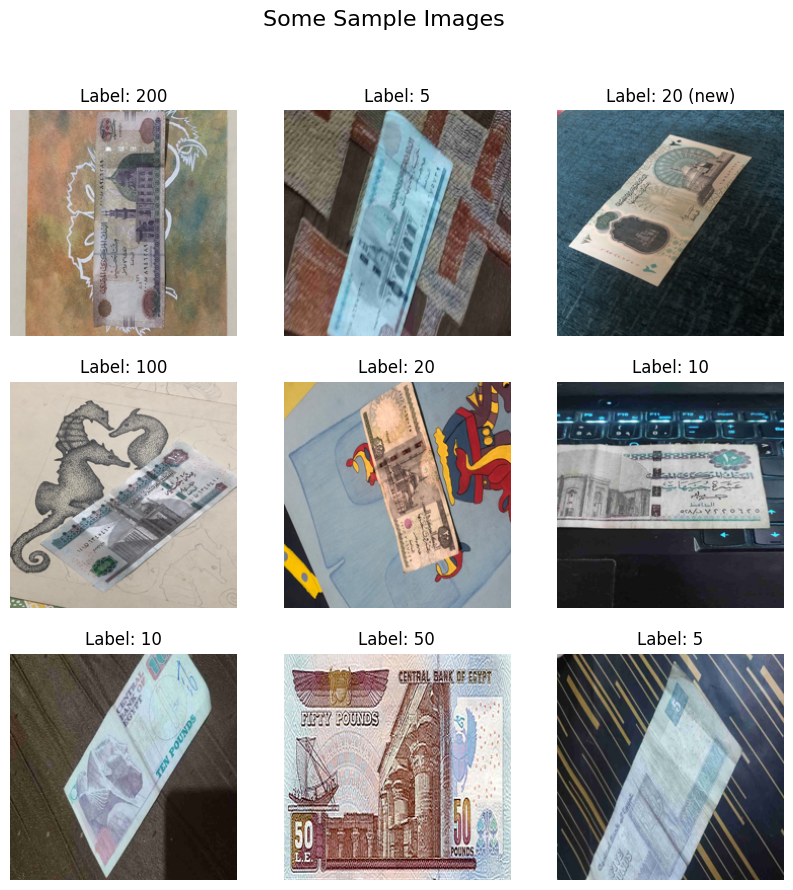

In [7]:
# Generate 9 random indices
sample_indices = random.sample(range(len(train_images)), 9)

# Create a 3x3 grid of subplots for plotting the images
plt.figure(figsize=(10, 10))
plt.suptitle("Some Sample Images", fontsize=16)

for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[idx])  # Assuming images are already in the appropriate format
    plt.title(f"Label: {train_labels[idx]}")
    plt.axis('off')

plt.show()

<h1 style="color:#e8710a">5) Encode Data</h1>

### Label Encoding and One-Hot Encoding

We perform label encoding and one-hot encoding on the training, validation, and test labels. 

1. **Label Encoding**: The `LabelEncoder` from `sklearn` is used to convert the class labels into numeric values.
   - The labels for the training, validation, and test sets are transformed into numerical format using `fit_transform` and `transform`.
   
2. **One-Hot Encoding**: The `to_categorical` function from Keras is used to convert the encoded labels into one-hot encoded vectors, which are required for multi-class classification tasks.
   - This ensures that the labels are in a format compatible with the neural network's output layer, where each class is represented by a vector with a single `1` in the position of the correct class and `0`s elsewhere.
   
The variable `num_classes` stores the total number of unique classes in the dataset.


In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)

train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
valid_labels_one_hot = to_categorical(valid_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

<h1 style="color:#e8710a">6) Some Helper Functions</h1>

In [9]:
def plot_history(history):   
    # Access the training history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Create subplots for loss and accuracy
    plt.figure(figsize=(12, 4))
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.tight_layout()
    plt.show()

In [10]:
def predict_class(model, test_images, test_labels, num_images_to_plot=12, num_columns=4):
    # Decode one-hot encoded labels
    test_labels = np.argmax(test_labels_one_hot, axis=1)
    
    # Choose random indices for testing
    random_indices = np.random.choice(len(test_images), size=num_images_to_plot, replace=False)

    # Calculate the number of rows needed based on the number of images and columns
    num_rows = int(np.ceil(len(random_indices) / num_columns))

    # Create a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3*num_rows))

    # Loop through the selected indices for prediction and plotting
    for i, ax in zip(random_indices, axes.flatten()):
        # Get the image and label
        image = test_images[i]
        label = test_labels[i]

        # Reshape the image to match the input shape expected by the model
        image = np.expand_dims(image, axis=0)

        # Predict the image using the loaded model
        prediction = model.predict(image)

        # Get the predicted label
        predicted_label = np.argmax(prediction)

        # Plot the image
        ax.imshow(image.squeeze())  # Squeeze to remove the singleton dimension
        ax.set_title(f"Actual Label: {label}\n Predicted Label: {predicted_label}")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

<h1 style="color:#e8710a">7) Modeling</h1>

In [11]:
# Define the number of epochs
NUM_CLASSES = num_classes
num_epochs = 200
batch_size = 32

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2, restore_best_weights=True)

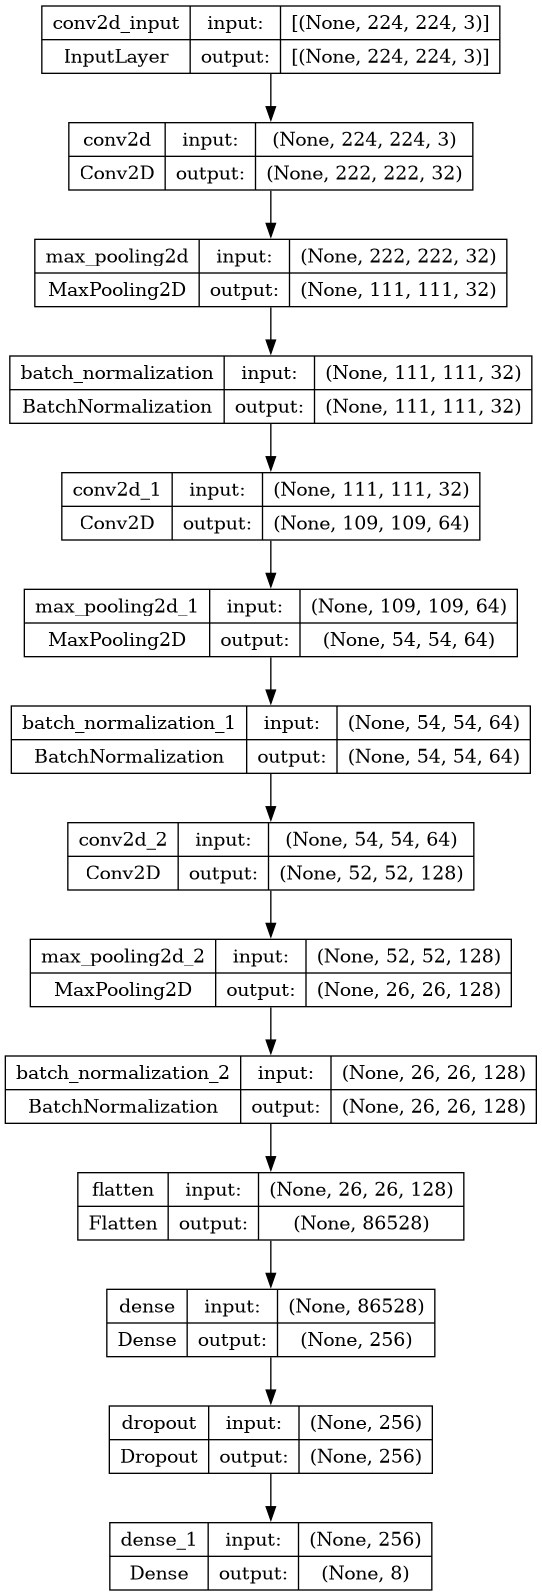

In [12]:
# Build the deep learning model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
# Start training the model
history = model.fit(
    train_images,
    train_labels_one_hot,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(valid_images, valid_labels_one_hot),
    callbacks=[early_stopping]
)

Epoch 1/200
81/81 [==============================] - 13s 43ms/step - loss: 25.1945 - accuracy: 0.2658 - val_loss: 28.4504 - val_accuracy: 0.3473
Epoch 2/200
81/81 [==============================] - 3s 31ms/step - loss: 7.6676 - accuracy: 0.3407 - val_loss: 14.1454 - val_accuracy: 0.3608
Epoch 3/200
81/81 [==============================] - 3s 31ms/step - loss: 4.1159 - accuracy: 0.3667 - val_loss: 7.6025 - val_accuracy: 0.3865
Epoch 4/200
81/81 [==============================] - 2s 30ms/step - loss: 3.3823 - accuracy: 0.3962 - val_loss: 18.4918 - val_accuracy: 0.3432
Epoch 5/200
81/81 [==============================] - 3s 31ms/step - loss: 2.7767 - accuracy: 0.4059 - val_loss: 4.6130 - val_accuracy: 0.3892
Epoch 6/200
81/81 [==============================] - 2s 30ms/step - loss: 2.2026 - accuracy: 0.4237 - val_loss: 7.8850 - val_accuracy: 0.4135
Epoch 7/200
81/81 [==============================] - 2s 30ms/step - loss: 2.1882 - accuracy: 0.4051 - val_loss: 22.7833 - val_accuracy: 0.2757


<h1 style="color:#e8710a">Training History</h1>

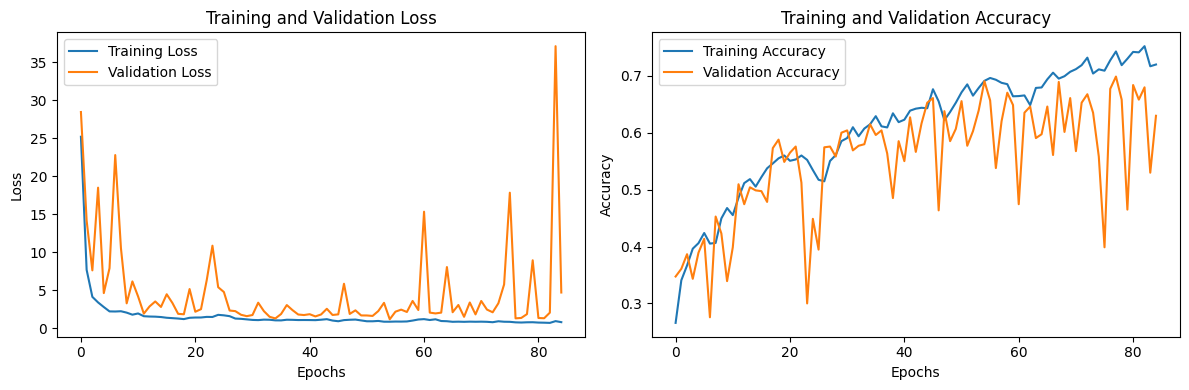

In [14]:
plot_history(history)

<h1 style="color:#e8710a">Model Evaluation</h1>

In [15]:
model.evaluate(test_images, test_labels_one_hot)

9/9 [==============================] - 0s 24ms/step - loss: 2.1192 - accuracy: 0.6741


[2.1191794872283936, 0.6740740537643433]

<h1 style="color:#e8710a">Model Prediction</h1>

1/1 [==============================] - 0s 17ms/step


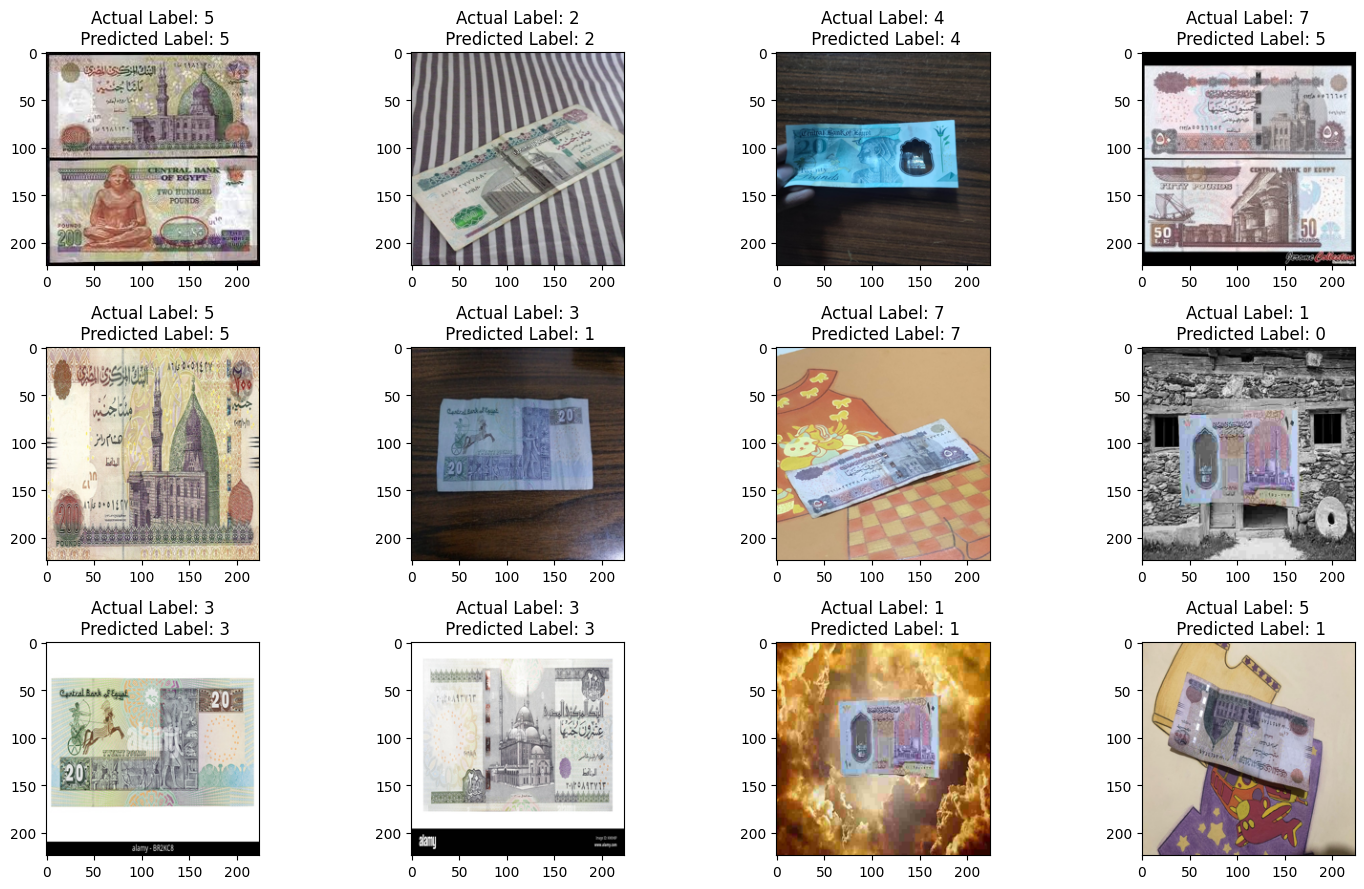

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
predict_class(model, test_images, test_labels_one_hot)

# save model
model.save('model-0.h5')

<hr>
<div style="background-color:#666666; padding:2rem 0">
<h1 style="color:#e2215a; text-align: center; font-size:60px">Transfer Learning</h1>
</div>

<h1 style="color:#e8710a">Model-1: EfficientNetV2L</h1>
This model uses **EfficientNetV2L** for transfer learning:

1. **Base Model**: Pre-trained EfficientNetV2L (ImageNet) without the top layer.
2. **New Layers**: Added `Flatten`, `Dense(512)`, `Dropout(0.5)`, and `Dense(NUM_CLASSES, softmax)` for classification.
3. **Freezing**: Base model layers are frozen to retain pre-trained features.
4. **Compilation**: Adam optimizer (LR=0.001) with categorical cross-entropy and accuracy.
5. **Training**: Model trained with early stopping and validation data.

#### Advantage:
**EfficientNetV2L** offers a great balance between accuracy and computational efficiency, making it ideal for handling large datasets with fewer resources compared to other models.

In [17]:
from tensorflow.keras.applications import EfficientNetV2L

base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_1 = Sequential()
model_1.add(base_model)  # Add the pre-trained model
model_1.add(Flatten())  # Flatten the output from the pre-trained model
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(NUM_CLASSES, activation='softmax'))  # Output layer
for layer in base_model.layers:
    layer.trainable = False
    
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model_1.fit(
    train_images,
    train_labels_one_hot,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(valid_images, valid_labels_one_hot),
    callbacks=[early_stopping]
)

473176280/473176280 [==============================] - 18s 0us/step
Epoch 1/200


2023-12-17 08:51:17.807332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


81/81 [==============================] - 60s 396ms/step - loss: 3.7117 - accuracy: 0.3384 - val_loss: 1.2609 - val_accuracy: 0.6297
Epoch 2/200
81/81 [==============================] - 23s 288ms/step - loss: 1.4857 - accuracy: 0.5378 - val_loss: 1.0324 - val_accuracy: 0.7095
Epoch 3/200
81/81 [==============================] - 23s 283ms/step - loss: 1.2939 - accuracy: 0.6217 - val_loss: 0.7590 - val_accuracy: 0.7757
Epoch 4/200
81/81 [==============================] - 22s 275ms/step - loss: 1.1118 - accuracy: 0.6702 - val_loss: 0.9138 - val_accuracy: 0.7703
Epoch 5/200
81/81 [==============================] - 23s 285ms/step - loss: 0.8513 - accuracy: 0.7322 - val_loss: 0.6983 - val_accuracy: 0.8311
Epoch 6/200
81/81 [==============================] - 23s 285ms/step - loss: 0.8002 - accuracy: 0.7482 - val_loss: 0.5348 - val_accuracy: 0.8500
Epoch 7/200
81/81 [==============================] - 23s 285ms/step - loss: 0.7338 - accuracy: 0.7827 - val_loss: 0.5068 - val_accuracy: 0.8473
Epoc

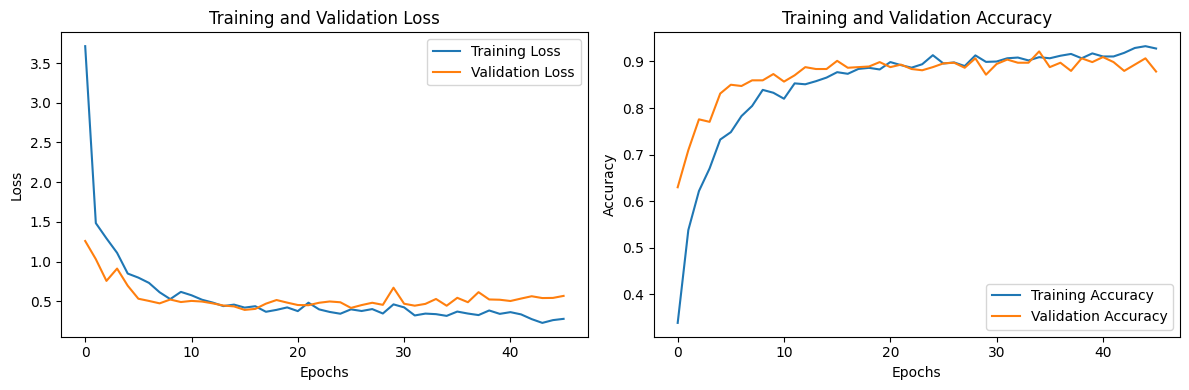

In [18]:
plot_history(history1)

<h2 style="color:#0099aa">Model Prediction</h2>

1/1 [==============================] - 0s 49ms/step


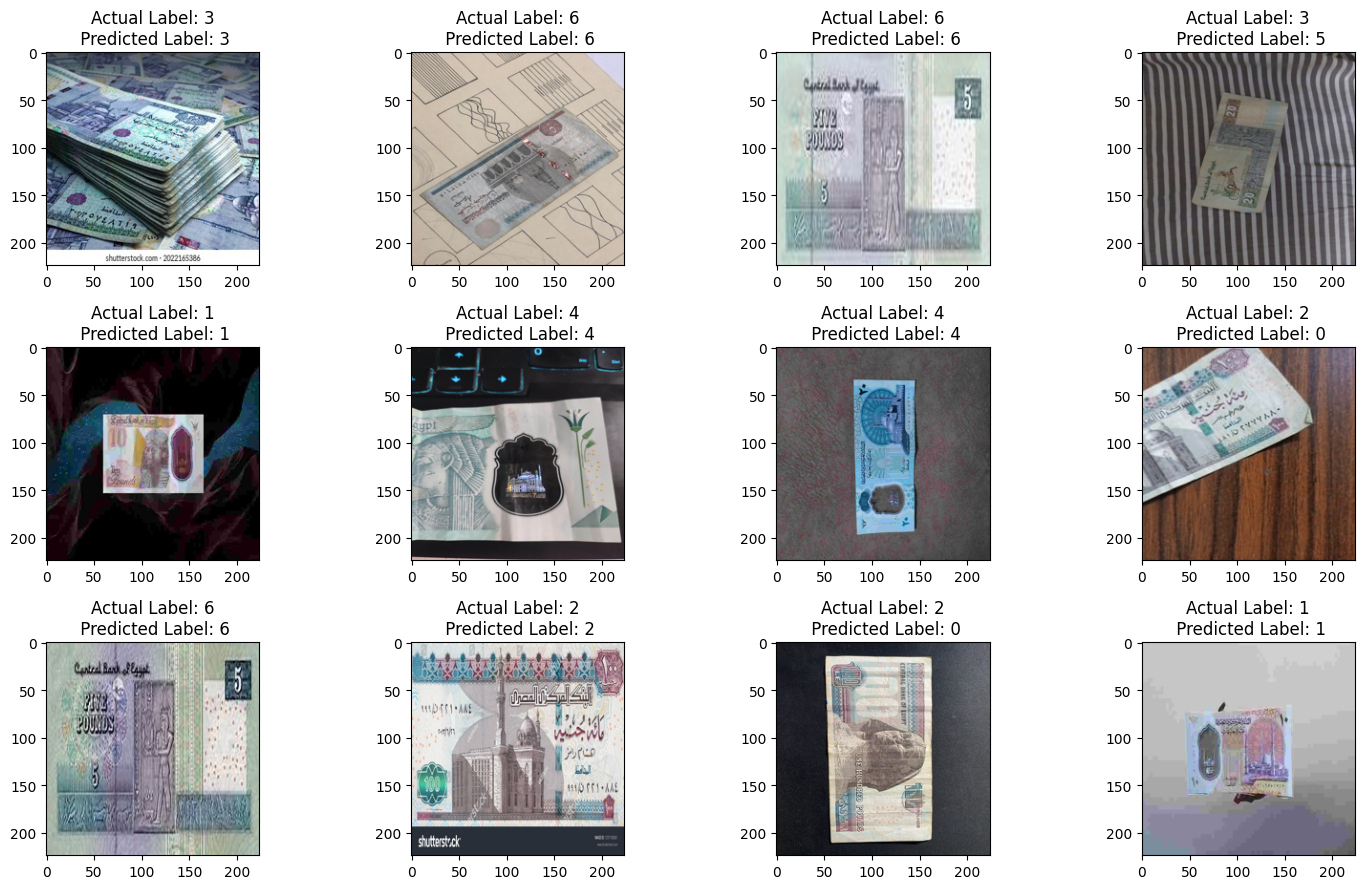

In [19]:
# test model
model_1.evaluate(test_images, test_labels_one_hot)

# predict
predict_class(model_1, test_images, test_labels_one_hot)

# save model
model_1.save('model_1.h5')

<hr>

<h1 style="color:#e8710a">Model-2: VGG16</h1>

### VGG16 Model

This model uses **VGG16** for transfer learning:

1. **Base Model**: Pre-trained VGG16 (ImageNet) without the top layer.
2. **New Layers**: Added `Flatten`, `Dense(512)`, `Dropout(0.5)`, and `Dense(NUM_CLASSES, softmax)` for classification.
3. **Freezing**: All base model layers are frozen to retain pre-trained features.
4. **Compilation**: Adam optimizer (LR=0.001), categorical cross-entropy loss, and accuracy metric.
5. **Training**: Trained with early stopping and validation data.


#### Disadvantage:
**VGG16** is large and memory-intensive, with many parameters, making it slower to train and requiring more computational resources.

In [20]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_2 = Sequential()
model_2.add(base_model)  # Add the pre-trained model
model_2.add(Flatten())  # Flatten the output from the pre-trained model
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(NUM_CLASSES, activation='softmax'))  # Output layer
for layer in base_model.layers:
    layer.trainable = False
    
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model_2.fit(
    train_images,
    train_labels_one_hot,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(valid_images, valid_labels_one_hot),
    callbacks=[early_stopping]
)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/200
81/81 [==============================] - 12s 110ms/step - loss: 1995.7831 - accuracy: 0.3718 - val_loss: 2.9721 - val_accuracy: 0.5000
Epoch 2/200
81/81 [==============================] - 7s 81ms/step - loss: 31598.9160 - accuracy: 0.4463 - val_loss: 7.4420 - val_accuracy: 0.5784
Epoch 3/200
81/81 [==============================] - 7s 81ms/step - loss: 112423.3750 - accuracy: 0.4385 - val_loss: 26.6268 - val_accuracy: 0.6405
Epoch 4/200
81/81 [==============================] - 7s 81ms/step - loss: 403768.8125 - accuracy: 0.4075 - val_loss: 99.7807 - val_accuracy: 0.5986
Epoch 5/200
81/81 [==============================] - 7s 81ms/step - loss: 603280.3750 - accuracy: 0.3562 - val_loss: 157.5069 - val_accuracy: 0.6216
Epoch 6/200
81/81 [==============================] - 7s 81ms/step - loss: 910021.6875 - accuracy: 0.3353 - val_loss: 276.6323 - val_accuracy: 0.6095
Epoch 7/200
81/81 [=============================

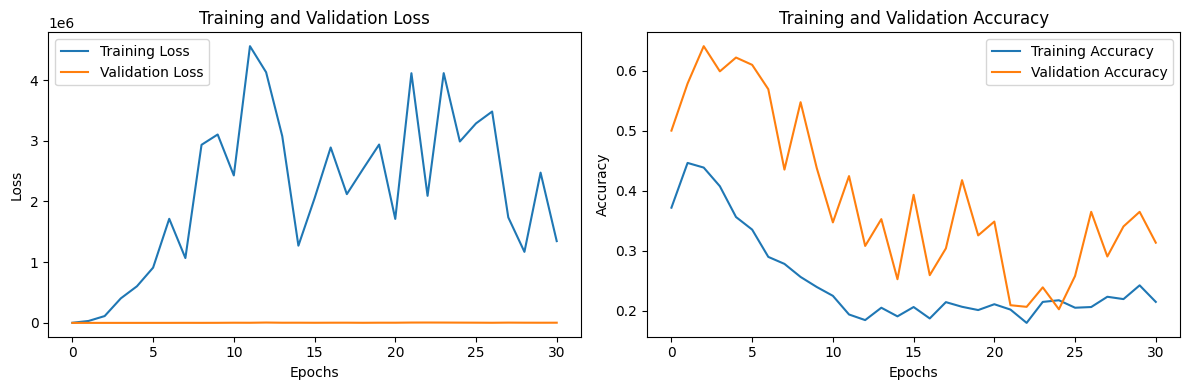

In [21]:
plot_history(history2)

<h2 style="color:#0099aa">Model Prediction</h2>

1/1 [==============================] - 0s 20ms/step


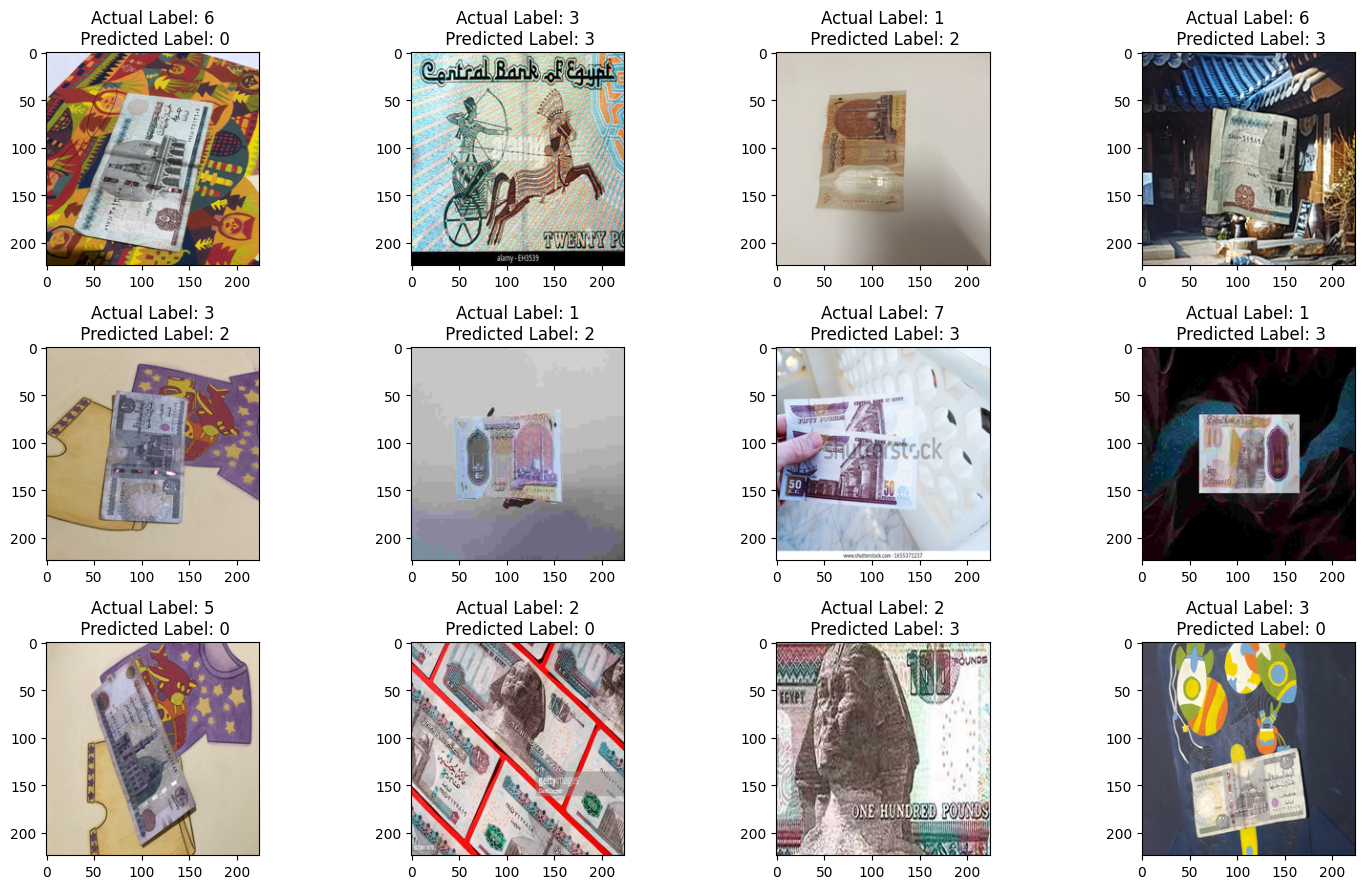

In [22]:
# test model
model_2.evaluate(test_images, test_labels_one_hot)

# predict
predict_class(model_2, test_images, test_labels_one_hot)

# save model
model_2.save('model_2.h5')

<hr>

<h1 style="color:#e8710a">Model-3: InceptionV3</h1>

### InceptionV3 Model

This model uses **InceptionV3** for transfer learning:

1. **Base Model**: Pre-trained InceptionV3 (ImageNet) without the top layer.
2. **New Layers**: Added `Flatten`, `Dense(512)`, `Dropout(0.5)`, and `Dense(NUM_CLASSES, softmax)` for classification.
3. **Freezing**: Base model layers are frozen to keep pre-trained features.
4. **Compilation**: Adam optimizer (LR=0.001), categorical cross-entropy loss, and accuracy metric.
5. **Training**: Trained with early stopping and validation data.


## Limitations

**InceptionV3** has a more complex architecture, which can make it harder to interpret and adjust. It may also be more difficult to integrate with different data types compared to simpler models.

In [23]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_3 = Sequential()
model_3.add(base_model)  # Add the pre-trained model
model_3.add(Flatten())  # Flatten the output from the pre-trained model
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(NUM_CLASSES, activation='softmax'))  # Output layer
for layer in base_model.layers:
    layer.trainable = False
    
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model_3.fit(
    train_images,
    train_labels_one_hot,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(valid_images, valid_labels_one_hot),
    callbacks=[early_stopping]
)

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/200
81/81 [==============================] - 14s 104ms/step - loss: 194.3826 - accuracy: 0.1502 - val_loss: 2.0935 - val_accuracy: 0.1135
Epoch 2/200
81/81 [==============================] - 5s 59ms/step - loss: 2.1255 - accuracy: 0.1339 - val_loss: 2.0859 - val_accuracy: 0.1108
Epoch 3/200
81/81 [==============================] - 5s 59ms/step - loss: 2.1088 - accuracy: 0.1257 - val_loss: 2.0735 - val_accuracy: 0.1122
Epoch 4/200
81/81 [==============================] - 5s 59ms/step - loss: 2.0786 - accuracy: 0.1312 - val_loss: 2.0732 - val_accuracy: 0.1770
Epoch 5/200
81/81 [==============================] - 5s 59ms/step - loss: 2.1301 - accuracy: 0.1350 - val_loss: 2.0729 - val_accuracy: 0.1770
Epoch 6/200
81/81 [==============================] - 5s 56ms/step - loss: 2.6335 - accuracy: 0.1366 - val_loss: 2.0731 - val_accuracy: 0.1770
Epoch 7/200
81/81 [==============================] - 5s 59ms/step - loss: 2.075

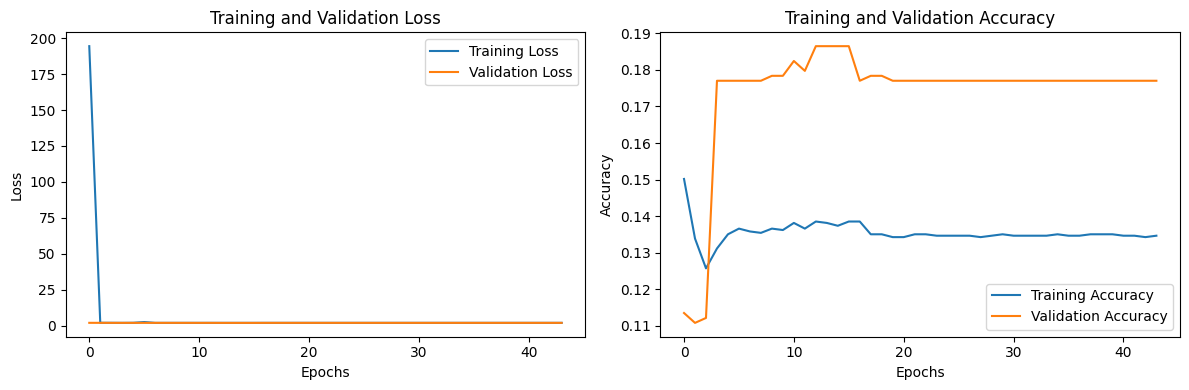

In [24]:
plot_history(history3)

<h2 style="color:#0099aa">Model Prediction</h2>

1/1 [==============================] - 0s 28ms/step


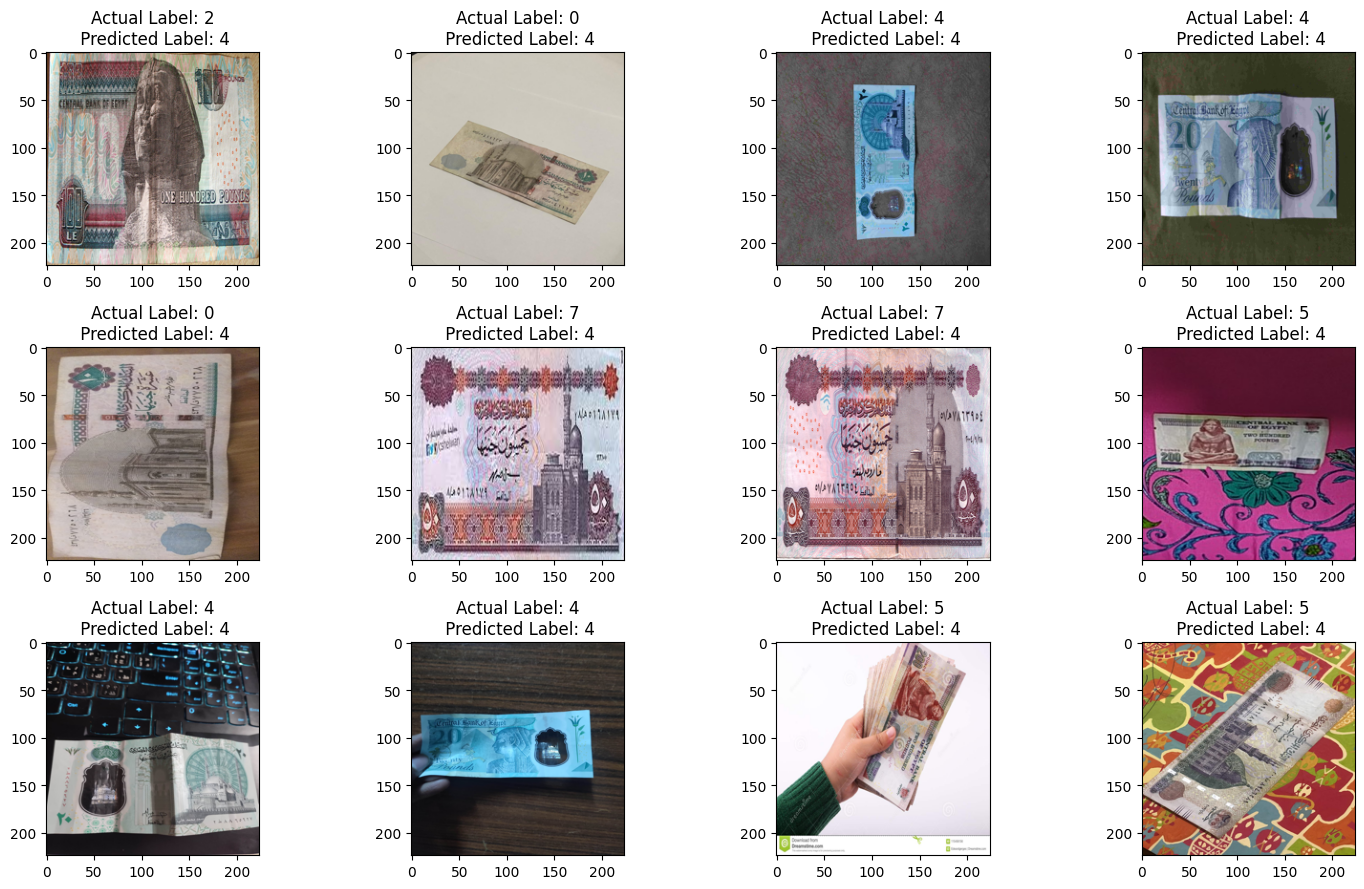

In [25]:
# test model
model_3.evaluate(test_images, test_labels_one_hot)

# predict
predict_class(model_3, test_images, test_labels_one_hot)

# save model
model_3.save('model_3.h5')

<hr>